### Imports

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
from IPython.display import display

### Plotting Style

In [84]:
sns.set_style("darkgrid")
plt.rcParams['axes.axisbelow'] = True

### Setting up Spark

In [85]:
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

# Create SparkSession 
spark = SparkSession.builder \
      .master("local[1]") \
      .appName("MarketBasketAnalysis") \
      .getOrCreate() 

# 1. Loading Data

In [86]:
tables=[]

print("=======================Aisles=======================")
aisles = pd.read_csv("Dataset/aisles.csv", sep=",")
display(aisles.head())
print("Aisles loaded with", len(aisles), "rows")
tables.append(aisles)

print("\n====================Departments=====================")
departments = pd.read_csv("Dataset/departments.csv", sep=",")
display(departments.head())
print("Departments loaded with", len(departments), "rows")
tables.append(departments)

print("\n=======================Orders=======================")
orders = pd.read_csv("Dataset/orders.csv", sep=",")
display(orders.head())
print("Orders loaded with", len(orders), "rows")
tables.append(orders)

print("\n====================Products========================")
products = pd.read_csv("Dataset/products.csv", sep=",")
display(products.head())
print("Products loaded with", len(products), "rows")
tables.append(products)

print("\n================Order Products Prior================")
ordProdPrior = pd.read_csv("Dataset/order_products__prior.csv", sep=",")
display(ordProdPrior.head())
print("Order Products Prior loaded with", len(ordProdPrior), "rows")
tables.append(ordProdPrior)

print("\n================Order Products Train================")
ordProdTrain = pd.read_csv("Dataset/order_products__train.csv", sep=",")
display(ordProdTrain.head())
print("Order Products Train loaded with", len(ordProdTrain), "rows")
tables.append(ordProdTrain)

=======================Aisles=======================


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


Aisles loaded with 134 rows

====================Departments=====================


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


Departments loaded with 21 rows

=======================Orders=======================


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Orders loaded with 3421083 rows

====================Products========================


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Products loaded with 49688 rows

================Order Products Prior================


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Order Products Prior loaded with 32434489 rows

================Order Products Train================


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


Order Products Train loaded with 1384617 rows


The dataset has over 3 million orders made by the company's customers. This shows the need of using big data processing frameworks later on the project.

# 2. Data Cleaning

### 2.1 Checking for missing values

In [87]:
#check whether there are missing values in every data table
print("Missing aisles?",aisles.isnull().values.any())
print("Missing departments?", departments.isnull().values.any())
print("Missing orders?", orders.isnull().values.any())
print("Missing products?", products.isnull().values.any())
print("Missing order products prior?", ordProdPrior.isnull().values.any())
print("Missing order products train?", ordProdTrain.isnull().values.any())


Missing aisles? False
Missing departments? False
Missing orders? True
Missing products? False
Missing order products prior? False
Missing order products train? False


Orders is the only table having missing values. We'll take a closer look.

In [88]:
#check which columns have missing values
print(orders.isnull().sum())

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


Days since prior order is the only column with missing values, which makes sense as a missing value most probably indicates that this is the customer's first order. Hence, I will not change anything.

# 3. Preprocessing

### 3.1 Checking for Outliers

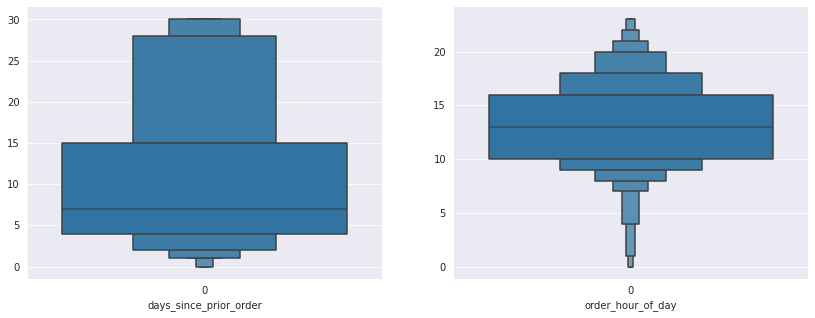

In [89]:
features = ["days_since_prior_order", "order_hour_of_day"]
fig, axs = plt.subplots(ncols=len(features), figsize=(7*len(features), 5))
for i in range(len(features)):
  sns.boxenplot(data=orders[features[i]],
                showfliers=True,
                ax=axs[i],
                ).set(xlabel=features[i])
  sns.despine()


The data seems to be clear of outliers. Overall, the data is clean and doesn't require preprocessing.

# 3. Feature Engineering

In [90]:
orders= orders.fillna(-1)
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,-1.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [91]:
orders_prod = orders.set_index('order_id').join(ordProdTrain.set_index('order_id')).reset_index().dropna()
orders_prod['department'] = products.set_index('product_id').loc[orders_prod['product_id'].astype(int)].department_id.values
orders_prod['department'] = departments.set_index('department_id').loc[orders_prod['department']].values
orders_prod.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department
0,1,112108,train,4,4,10,9.0,49302.0,1.0,1.0,dairy eggs
1,1,112108,train,4,4,10,9.0,11109.0,2.0,1.0,dairy eggs
2,1,112108,train,4,4,10,9.0,10246.0,3.0,0.0,produce
3,1,112108,train,4,4,10,9.0,49683.0,4.0,0.0,produce
4,1,112108,train,4,4,10,9.0,43633.0,5.0,1.0,canned goods


In [92]:
users_stats = pd.DataFrame()

# Getting total count of orders
users_stats['total_orders'] = orders_prod.groupby('user_id').order_id.count()

# Getting total count of orders in each dow
users_dow_count = orders_prod.groupby('user_id').order_dow.value_counts().unstack().fillna(0)
for dow in users_dow_count.columns:
    users_stats[f'dow_{dow}']=users_dow_count[dow]

# Getting ordering rate
users_stats['order_every'] = orders_prod.groupby('user_id').days_since_prior_order.mean()

# Getting count of each department
users_department_count = orders_prod.groupby('user_id').department.value_counts().unstack().fillna(0)
for department in users_department_count.columns:
    users_stats[f'department_{department}']=users_department_count[department]
    
# Getting average basket size for each user
users_stats['basket_size'] = orders_prod.groupby(['user_id','order_id']).product_id.count().reset_index().groupby('user_id').product_id.mean()

users_stats.head()

,total_orders,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,order_every,department_alcohol,...,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks,basket_size
user_id,,,,,,,,,,,,,,,,,,,,,
1,11,0.0,0.0,0.0,0.0,11.0,0.0,0.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0
2,31,0.0,31.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,5.0,31.0
5,9,9.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,9.0
7,9,0.0,0.0,9.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,9.0
8,18,0.0,18.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.0,0.0,18.0


In [93]:
departments['department']

0              frozen
1               other
2              bakery
3             produce
4             alcohol
5       international
6           beverages
7                pets
8     dry goods pasta
9                bulk
10      personal care
11       meat seafood
12             pantry
13          breakfast
14       canned goods
15         dairy eggs
16          household
17             babies
18             snacks
19               deli
20            missing
Name: department, dtype: object

In [94]:
aisles['aisle'].values

array(['prepared soups salads', 'specialty cheeses',
       'energy granola bars', 'instant foods',
       'marinades meat preparation', 'other', 'packaged meat',
       'bakery desserts', 'pasta sauce', 'kitchen supplies',
       'cold flu allergy', 'fresh pasta', 'prepared meals',
       'tofu meat alternatives', 'packaged seafood', 'fresh herbs',
       'baking ingredients', 'bulk dried fruits vegetables',
       'oils vinegars', 'oral hygiene', 'packaged cheese', 'hair care',
       'popcorn jerky', 'fresh fruits', 'soap', 'coffee', 'beers coolers',
       'red wines', 'honeys syrups nectars', 'latino foods',
       'refrigerated', 'packaged produce', 'kosher foods',
       'frozen meat seafood', 'poultry counter', 'butter',
       'ice cream ice', 'frozen meals', 'seafood counter',
       'dog food care', 'cat food care', 'frozen vegan vegetarian',
       'buns rolls', 'eye ear care', 'candy chocolate', 'mint gum',
       'vitamins supplements', 'breakfast bars pastries',
       '

# 4. Segmentation

In this section, Spark will be used to apply k-means clustering on the data using map reduce.

### 4.1 Customer-level Segmentation

#### 3.2 Feature generation

In [95]:
df= spark.createDataFrame(orders.head(20))

In [96]:
df.printSchema()

root
 |-- order_id: long (nullable = true)
 |-- user_id: long (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: long (nullable = true)
 |-- order_dow: long (nullable = true)
 |-- order_hour_of_day: long (nullable = true)
 |-- days_since_prior_order: double (nullable = true)



In [98]:
#put features together into column using spark's vector assembler
vecAssembler = VectorAssembler(inputCols=["order_hour_of_day"], outputCol="features")
new_df = vecAssembler.transform(df)
# new_df.printSchema()

# Trains a k-means model.
kmeans = KMeans().setK(3).setSeed(1)
# new_df.show(n=2)
# model = kmeans.fit(new_df.select('features'))
# # Make predictions
# predictions = model.transform(df)

# # Evaluate clustering by computing Silhouette score
# evaluator = ClusteringEvaluator()
# silhouette = evaluator.evaluate(predictions)
# print("Silhouette with squared euclidean distance = " + str(silhouette))
# # Evaluate clustering.
# cost = model.computeCost(df)
# print("Within Set Sum of Squared Errors = " + str(cost))
# # Shows the result.
# print("Cluster Centers: ")
# ctr=[]
# centers = model.clusterCenters()
# for center in centers:
#     ctr.append(center)
#     print(center)